# <font color = '#00CCFF'> High Value Customer Identification </font>

Project Objective: Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups:

Dataset Description: This is a transnational dataset that contains all the transactions occurring between Nov-2016 to Dec-2017 for a UK-based online retail store.

Attribute Description:
- InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode: Product (item) code
- Description: Product (item) name
- Quantity: The quantities of each product (item) per transaction
- InvoiceDate: The day when each transaction was generated
- UnitPrice: Unit price (Product price per unit)
- CustomerID: Customer number (Unique ID assigned to each customer)
- Country: Country name (The name of the country where each customer resides)

### Output:

1. A indicação de pessoal para fazer parte do programa de "INSIDEERS"
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição dos inseiders no faturamento?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao grupo?
    - Quais as condições para uma pessoa ser removida do grupo?
    - Qual a garantia que o programa é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import scikitplot as skplt
#import plotly.express as px
import re

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy

import umap.umap_ as umap

## 0.2. Functions

## 0.3. Load dataset

In [2]:
path = '/home/ezequiel/Documentos/Comunidade_DS/insiders_clustering/data/raw/Ecommerce.zip'
df_raw = pd.read_csv(path, encoding='unicode_escape', compression='zip')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1. Descrição dos dados

In [3]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [5]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

InvoiceNo should be a number, but some records have letters

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [8]:
# Procurar se há algum customer_id "perdido" a partir do invoice_no
#df_missing = df1[df1['customer_id'].isna()]
#df_not_missing = df1[~df1['customer_id'].isna()]

df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
df_not_missing.shape

(406829, 8)

In [10]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [12]:
#df1 = df1.dropna(subset=['description', 'customer_id'])

## 1.6. Change dtyper

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## 1.7. Descriptive statistics

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical attributes

In [16]:
df_describe = num_attributes.describe().T
df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe['median'] = num_attributes.median()
df_describe['skewness'] = num_attributes.skew()
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe.reset_index()

,index,count,mean,std,min,25%,50%,75%,max,range,median,skewness,kurtosis
0,quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,161990.00,3.00,-0.264076,119769.160031
1,unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,50032.06,2.08,186.506972,59005.719097
2,customer_id,541909.0,16688.840453,2911.411352,12346.00,14367.00,16249.00,18283.00,22709.0,10363.00,16249.00,0.487449,-0.804287


### 1.7.2. Categorical attributes

#### Invoice_no

In [17]:
# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock_code

In [18]:
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [19]:
# verifica se stock_code contém somente letras e mostra a quantidade de ocorrências
df1.loc[~df1['stock_code'].str.contains('[0-9]'), 'stock_code'].value_counts()

stock_code
POST            1256
DOT              710
M                571
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
PADS               4
B                  3
m                  1
Name: count, dtype: int64

#### Country

In [20]:
df1['country'].value_counts(normalize=True)

country
United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
Eu

# 2. Variables Filtering

In [51]:
df2 = df1.copy()

In [52]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [53]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3. Feature Engineering

In [54]:
df3 = df2.copy()

In [55]:
# data reference - group by customer
#df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

#### **Gross revenue (Faturamento)**

Faturamento para cada produto = quantidade x preço

In [58]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/tmp/ipykernel_24529/206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### **Recency**

How recent is the last purchase made by each customer.

In [61]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### **Quantity of products purchased**

In [63]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

In [31]:
### 3.1.3. Quantity of purchased 
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity total of items purchased 

In [32]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
qtde_invoices    91
qtde_items       91
dtype: int64

#### **Frequency purchase**

In [65]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

#### **Number of returns**

In [67]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

In [68]:
df_ref.describe()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
count,5786.000000,5695.000000,5695.000000,5695.000000,5695.000000,5786.000000
mean,16640.755271,1774.303486,116.927656,92.609482,0.547297,31.403387
std,2825.257249,7582.209661,111.646363,210.578598,0.550257,996.500643
min,12346.000000,0.420000,0.000000,1.000000,0.005450,0.000000
25%,14306.250000,236.135000,23.000000,14.000000,0.024926,0.000000
50%,16269.000000,613.200000,71.000000,41.000000,1.000000,0.000000
75%,18261.750000,1570.740000,200.000000,106.000000,1.000000,1.000000
max,22709.000000,279138.020000,373.000000,7838.000000,17.000000,74215.000000


In [69]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,17850,5391.21,372.0,297.0,17.000000,40.0
1,13047,3232.59,56.0,171.0,0.028302,35.0
2,12583,6705.38,2.0,232.0,0.040323,50.0
3,13748,948.25,95.0,28.0,0.017921,0.0
4,15100,876.00,333.0,3.0,0.073171,22.0


# 4. EDA (Exploratory Data Analysis)

In [70]:
df4 = df_ref.dropna()

## 4.3. Estudo do Espaço

In [74]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy() 

In [77]:
df43.describe()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
count,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000
mean,16600.598946,1774.303486,116.927656,92.609482,0.547297,31.268306
std,2808.241892,7582.209661,111.646363,210.578598,0.550257,1004.321707
min,12346.000000,0.420000,0.000000,1.000000,0.005450,0.000000
25%,14288.500000,236.135000,23.000000,14.000000,0.024926,0.000000
50%,16227.000000,613.200000,71.000000,41.000000,1.000000,0.000000
75%,18210.500000,1570.740000,200.000000,106.000000,1.000000,1.000000
max,22709.000000,279138.020000,373.000000,7838.000000,17.000000,74215.000000


In [78]:
mm = MinMaxScaler()

In [79]:
df43['gross_revenue']  = mm.fit_transform( df43[['gross_revenue']] )

df43['recency_days']   = mm.fit_transform( df43[['recency_days']] )

df43['qtde_products']  = mm.fit_transform( df43[['qtde_products']])

df43['frequency']      = mm.fit_transform( df43[['frequency']])

df43['qtde_returns']   = mm.fit_transform( df43[['qtde_returns']])

In [80]:
df43.describe()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
count,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000
mean,16600.598946,0.006355,0.313479,0.011689,0.031884,0.000421
std,2808.241892,0.027163,0.299320,0.026870,0.032378,0.013533
min,12346.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14288.500000,0.000844,0.061662,0.001659,0.001146,0.000000
50%,16227.000000,0.002195,0.190349,0.005104,0.058522,0.000000
75%,18210.500000,0.005626,0.536193,0.013398,0.058522,0.000013
max,22709.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 4.3.4. Tree-Based Embedding

In [81]:
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [82]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

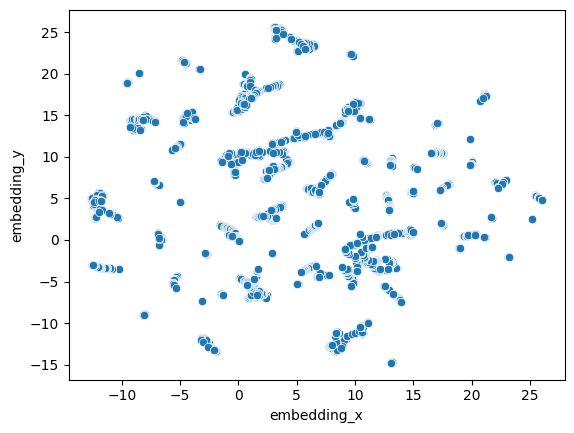

In [83]:
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_tree)

# 5. Data Preparation

**Dica:**

Rescale vs. Standardization
1. Se os dados possuem distribuição normal e não possui outlier -> Standard scaler
2. Se os dados possuem distribuição normal e possui outlier -> Robust scaler
3. Se os dados não possuem distribuição normal -> MinMax scaler

Rescale --> $\frac{Valor - min(Valor)}{max(Valor) - min(Valor)}$ --> Adimensional
 
Standardization --> $\frac{Valor - média(Valor)}{desvioPadrao(Valor)}$ --> Adimensional

**Testes de Normalização:**

* QQ Plot - Quantile Quantile Plot (quantil teorico vs. quantil real)
* KS Test - Kolgomorov Smirnoff (teste de hipóteses):
    * p-value > 0.5, distribuição normal
    * p-value < 0.5, distribuição não normal

**Detecção de Outliers:**
* Boxplot --> pontos são identificados como outliers
* Pontos acima da distância interquartil X 2,5 --> outliers
* Z-score > 3 ou Z-score < -3 --> outliers

In [84]:
df5 = df_tree.copy()

# 7. Hyperparameter Fine Tunning

In [85]:
X = df_tree.copy()

In [86]:
X.head()

,embedding_x,embedding_y
0,5.784434,12.569183
1,-1.097979,10.053894
2,5.336053,12.358485
3,-2.359059,-12.806021
4,21.705599,2.660258


# 8. Model Training

## 8.1. Final model - GMM

In [87]:
k = 8
gmm_model = GaussianMixture(n_components=k, n_init=300, random_state=32)
gmm_model.fit(X)
labels = gmm_model.predict(X)

## 8.2. Cluster Validation

In [88]:
print(f'SS value: {silhouette_score(X, labels=labels, metric="euclidean")}')

SS value: 0.33029818534851074


# 9. Cluster Analisys

In [ ]:
df9 = X.copy()
#df9 = df7.copy()
df9['cluster'] = labels
df9.head()

## 9.1. Visualization

In [ ]:
sns.scatterplot(data=df9, x='embedding_x', y='embedding_y', hue='cluster', palette='deep')

## 9.2. Cluster profile

In [ ]:
# Saindo do espaço de embedding para o espaço de features
df92 = df4[cols_selected].copy()
df92['cluster'] = labels

In [ ]:
df92.head()

In [ ]:
# Number of customers
df_clusters = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Number of customers (%)
df_clusters['% customer_id'] = (df_clusters[['customer_id']] / df_clusters[['customer_id']].sum()) * 100

# Average gross revenue
aux1 = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

# % Gross revenue
aux2 = (df92[['cluster', 'gross_revenue']].groupby('cluster').sum() / df92['gross_revenue'].sum()).reset_index().rename(columns={'gross_revenue': '% gross_revenue'})

# Average recency
aux3 = df92[['recency', 'cluster']].groupby('cluster').mean().reset_index()

# Average invoice no
#aux4 = df92[['qtd_invoices', 'cluster']].groupby('cluster').mean().reset_index()

# Average qtd_products
aux4 = df92[['qtd_products', 'cluster']].groupby('cluster').mean().reset_index()

# Average frequency
aux5 = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()

# Average returns
aux6 = df92[['returns', 'cluster']].groupby('cluster').mean().reset_index()

In [ ]:
df_clusters = pd.merge(df_clusters, aux1, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux2, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux3, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux4, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux5, on='cluster', how='left')
df_clusters = pd.merge(df_clusters, aux6, on='cluster', how='left')

In [ ]:
df_clusters_sorted = df_clusters.sort_values(by=['gross_revenue'], ascending=False).reset_index(drop=True)
df_clusters_sorted

In [ ]:
insider_cluster_no = df_clusters_sorted.loc[0, 'cluster']

| Cluster | Nome |
|:-------:|------|
| 6 | Insiders |
| 1 | Spend more |
| 2 | More products |
| 5 | Even more spending |
| 4 | Almost there |
| 7 | Low buy and return |
| 0 | No more return |
| 3 | Lazzy boys |

In [ ]:
df_clusters_sorted

---

**Cluster 3 (candidatos à insiders)**:
- Número de customers: 468 (15,78%)
- Faturamento médio: US$ 8.835,98
- Recência média: 21,45
- Média de compras: 424,12
- Frequência de compra: 0,065 produtos/dia
---

# 10. Exploratory Data Analisys

In [ ]:
df10 = df92.copy()
df10.head()

## 10.1. MindMap de hipóteses

1. Fenômeno
2. Entidades (customer, location, finance, family)
3. Características da entidade --> Ex.: customer=(nome, idade, salário, escolaridade)

## 10.2. Hipóteses de negócio

![Clusterização de clientes de um e-commerce.png](<attachment:Clusterização de clientes de um e-commerce.png>)
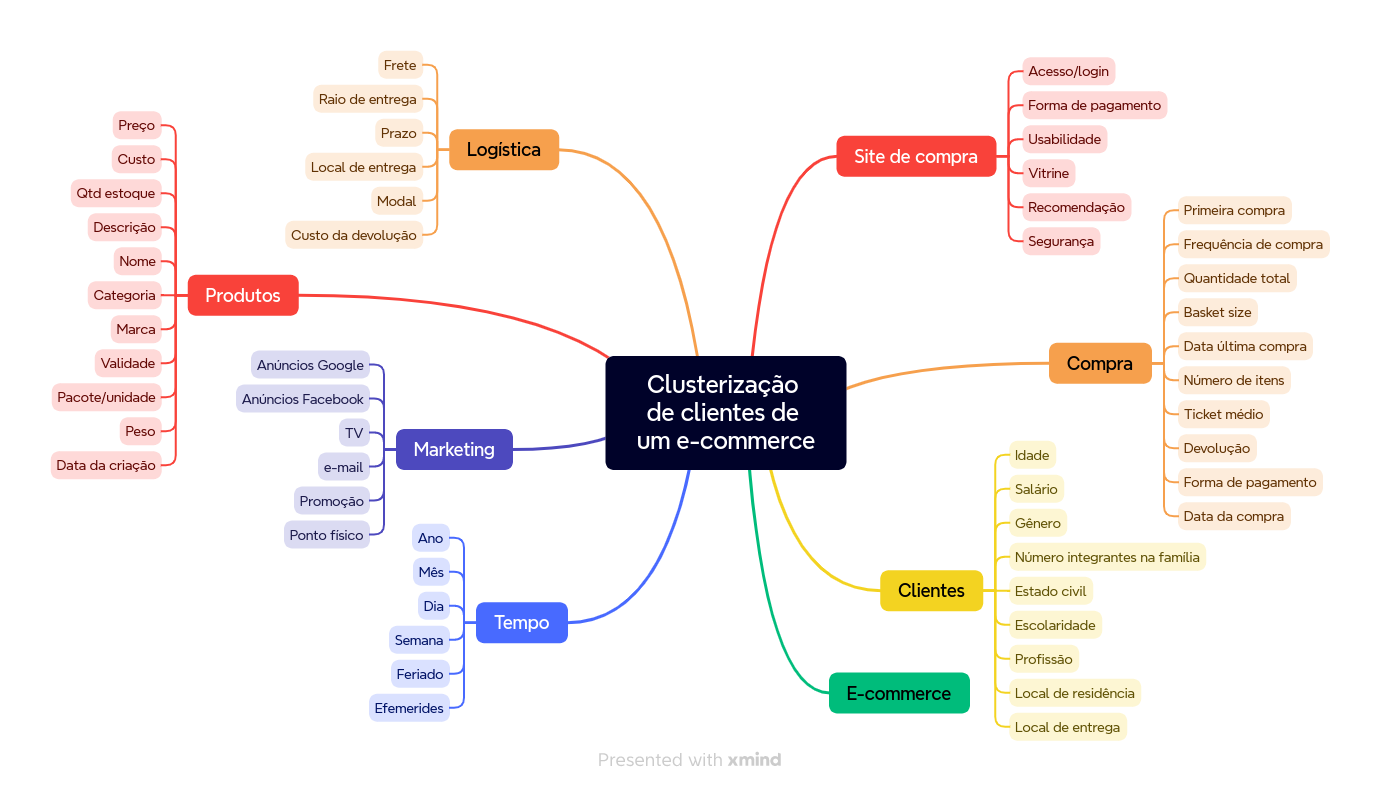

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

Cluster | Variável para testar | Base comparação

### 10.2.1 Hipótese Compra

1. Os clientes do cluster Insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster Insiders possuem um ticket médio de 10% acima do cluster Spend more.
3. Os clientes do cluster Insiders possuem um basket size médio acime de 5 produtos.
4. **Os clientes do cluster Insiders representam mais de 10% do volume (produtos) total de compras.**
5. **Os clientes do cluster Insiders representam mais de 10% do volume (faturamento) total de compras.**
6. **Os clientes do cluster Insiders tem a quantidade média de devoluções abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster Insiders é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do GMV pelos clientes do cluster Insiders.**

### H1: Os clientes do cluster Insiders representam mais de 10% do volume (produtos) total de compras
**Verdadeiro:** O cluster Insiders representa 54,49% do total de compras.

In [ ]:
total = df10['qtd_products'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['qtd_products'].sum()
print(f'O volume de produtos dos insiders representa {(insiders/total)*100:.2f}% do total de compras.')

### H2: Os clientes do cluster Insiders representam mais de 10% do volume (faturamento) total de compras
**Verdadeiro:** O cluster Insiders representa 51,74% do total de compras.

In [ ]:
total = df10['gross_revenue'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].sum()
print(f'O volume de receita com os insiders representa {(insiders/total)*100:.2f}% do total de compras.')

### H3: Os clientes do cluster Insiders tem a quantidade média de devoluções abaixo da média da base total de clientes.
**Falsa:** A média de devoluções do cluster Insiders é 428.60% maior do que a média total.

In [ ]:
total_avg_return = df10['returns'].mean()
insiders_avg_return = df10.query('cluster == @insider_cluster_no')['returns'].mean()
print(f'Média total: {total_avg_return:.2f}')
print(f'Média dos Insiders: {insiders_avg_return:.2f}')
print(f'A média de devoluções do cluster Insiders é {(insiders_avg_return/total_avg_return)*100:.2f}% maior do que a média total.')

### H4: A mediana do faturamento dos clientes do cluster Insiders é 10% maior do que a mediana do faturamento geral.
**Verdadeira:** A mediana dos Insiders é 275,99% maior do que a mediana total.

In [ ]:
# mediana de gmv Insiders
median_gmv_insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].median()

# mediana de gmv total
median_gmv_total = df10['gross_revenue'].median()

diff_median = ((median_gmv_insiders - median_gmv_total) / median_gmv_total) * 100

print(f'{diff_median:.2f}%')

### H5: O percentil do GMV pelos clientes do cluster Insiders está concentrada no quartil 3.
**Falsa:** O faturamento está concentrado no quartil 1

In [ ]:
np.percentile(df10.query('cluster == @insider_cluster_no')['gross_revenue'], q=0.1)

In [ ]:
np.percentile(df10.query('cluster == @insider_cluster_no')['gross_revenue'], q=0.9)

In [ ]:
sns.violinplot(x=df10.query('cluster == @insider_cluster_no & gross_revenue < 50000')['gross_revenue'], inner='quart')

### 10.2.2. Hipótese Cliente

1. 60% dos clientes do cluster Insiders são solteiros.
2. 10% dos clientes do cluster Insiders estão na faixa de 24-35 anos.
3. 40% dos clientes do cluster Insiders possuem localidade de entrega dentro de um raio de 50 km.
4. 5% dos clientes do cluster Insiders recebem mais de US$ 100k anual.
5. 90% dos clientes do cluster Insiders possuem ensino superior completo.

### 10.2.3. Hipótese Produto

1. 30% dos produtos em pacotes grandes são comprados pelos clientes do cluster Insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior do que a mediana de todos os preços dos produtos
3. O percentil do preço dos produtos comprados pelos clientes do cluster Insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior do que o peso médio dos demais clusters.
5. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor do que 15 dias.

### 10.2.4. Perguntas de negócio

#### 1. Quem são as pessoas elegíveis para participar do programa?

In [ ]:
df10.query('cluster == @insider_cluster_no')['customer_id'].head()

#### 2. Quantos clientes farão parte do grupo?

In [ ]:
df10.query('cluster == @insider_cluster_no')['customer_id'].nunique()

#### 3. Quais as principais características desses clientes?

**Cluster Insiders**:
- Número de customers: 468 (15,78%)
- Faturamento médio: US$ 8.835,98
- Recência média: 21,45
- Média de compras: 424,12
- Frequência de compra: 0,065 produtos/dia
---

#### 4. Qual a porcentagem de contribuição dos insiders no faturamento?

In [ ]:
total = df10['gross_revenue'].sum()
insiders = df10.query('cluster == @insider_cluster_no')['gross_revenue'].sum()
print(f'O volume de receita com os insiders representa {(insiders/total)*100:.2f}% do total de compras.')

#### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

#### 6. Quais as condições para uma pessoa ser elegível ao grupo?

#### 7. Quais as condições para uma pessoa ser removida do grupo?

#### 8. Qual a garantia que o programa é melhor que o restante da base?

#### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.3. Priorização das hipóteses

## 10.4. Validação das hipóteses

## 10.5. Quadro de resultados

# 11. Deploy to Production